# Chapter 1 - My First Simulation (10 min)
![Laplace](PyFEMP_src/assets/laplace_a.jpeg?raw=true "A simple laplace bvp.")

For a PyFEMP simulation we start with importing four things into our python session:
 * numpy
 * matplotlib
 * PyFEMP
 * the element we will use

In [1]:
# Import Numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import the PyFEMP package
import PyFEMP

For this example we use a quadrilateral finite element for solving the head conductivity problem. For its documentation, see ... . 

By convention we introduce the PyFEMP element of a simulation with the pattern:
```
import ELEMENTFILE as ELEMENT
```

Here we use a PyFEMP element file: `PyFEMP.elements.Laplace_Q1`

In [3]:
# Importing the element file
import PyFEMP.elements.Laplace_Q1 as ELEMENT 

We start a simulation by creating a FEM_Simulation object.

The Element were about to use was imported as `ELEMENT` which is the only required argument. 

Here we additionally set the simulation to be verbose from the beginning on (opional).

In [4]:
MyFirstSimulation = PyFEMP.FEM_Simulation(ELEMENT, verbose=True)

FEM Solver Instance Created
Simulation dimensions:                     2
Number of element nodes:                   4
Names of nodal degrees of freedom:         ['T']
Names of element parameters:               ['alpha_q']
Names of available postprocessing fields:  ['T']


In [5]:
# A simulation may provide a lot of information which can be controlled by two switches which are off by default. Their value can be changed anytime during the simulation
MyFirstSimulation.verbose        = True
MyFirstSimulation.verbose_system = True

Now we define the problem, starting with a definition for the mesh. With this very simple example we can define the mesh manually

In [6]:
# Add a FEM-Mesh
XI   = np.array([[0.0, 0.0],[1.0, 0.0],[1.0, 1.0],[0.0, 1.0]])
Elmt = np.array([[0,1,2,3]])
MyFirstSimulation.Add_Mesh(XI, Elmt)

Mesh NoNodes          :  4
Mesh Dimension        :  2
Mesh NoElements       :  1
Mesh Nodes per Element:  4
 Finite Elemenmt Mesh Read!


Next we introduce the material parameters. Here 'All' elements share the same parameter vector.

In [7]:
# Set homogenous material
MyFirstSimulation.Add_Material([1.0], 'All')

 Material set for All Elements


Two sets of boundary conditions must be set in this problem. At first we introduce the essential conditions (or Dirichlet), where a fixed value is prescirbed.

The Add_EBC command is used to introduce this type of boundary conditions. It takes three arguments. The first is a condition string, which is evaluated to find the nodes by their coordinates. In this example we do know the nodal coordinates to target precisely, however the second way of specifying a node (upper right corner) shows the capabilities of this method. The second argument is a string with the nodal degree of freedom name as specified in the element file. In this case we address the temperature `'T'`. The last argument specifies the prescribed value.

In [8]:
# Add essential boundary conditions
MyFirstSimulation.Add_EBC('x==0 and y==0', 'T', 0.0)
MyFirstSimulation.Add_EBC('x>0.8 and y>0.8', 'T', 3.0)

>> Note that all boundary conditions are multiplied with a scalar, introduced in the NextStep command later.

In a similar fashion we introduce the natural (or Neumann) boundary condition. This will be a heat flux at the non prescribed nodes.

In [9]:
# Add natural boundary conditions
MyFirstSimulation.Add_NBC('x==1 and y==0', 'T', -100.0)
MyFirstSimulation.Add_NBC('x==0 and y==1', 'T',  100.0)

Once the boundary value problem is prescribed, we enter the analsis phase of the simulation. After this point, all boundary conditions are fixed and history/degrees of freedom fields are initialized.

In [10]:
# Enter analysis phase - get ready for solving the problem
MyFirstSimulation.Analysis()

Entering Analysis phase
---------------------------------
FE Setup Summary :
NoElementNodes   : 4
NoNodeDofs       : 1
ElementDofNames  : ['T']
ElementPostNames : ['T']
NoElementHistory : 0
NoElements       : 1
NoNodes          : 4
NoDofs           : 4
NoEssential BC   : 2
NoNatural BC     : 2
---------------------------------


In [11]:
# Check the vector of degrees of freedom after initialization
MyFirstSimulation.DI

array([0., 0., 0., 0.])

While all values and loads are initialied by zero, we introduce a time/load step to apply the boundary conditions to the simulation.
The `NextStep` command takes two arguments. The first is the absolute time, for which we attempt to find a solution. The second argument is the value of the load multiplier, applied to all boundary conditions.

Note that although the problem is stready state, we introduce a time, which value is not relevant here. Also because the problem is linear, the load can be applied at once immediately.

In [12]:
# Make a time step
MyFirstSimulation.NextStep(1.0, 1.0)


Current Time : 1.0000005.2


To utilize the implemented Newton-Raphson algorithm to solve the problem, we invoke a predefined macro to execute `NewtonIteration`s. Details on this will be provided later.

Recognize that we print out the return of the function call, to obtain an indicator value for satisfaction of the residual.

To limit the amount of output, we will switch the verboseness off. However, feel free to inspect the output with verboseness on.

In [13]:
# Typical solution procedure for a linear problem,
# by calling NewtonIteration() twice to inspect its output
MyFirstSimulation.verbose        = False
print( MyFirstSimulation.NewtonIteration() )
print( MyFirstSimulation.NewtonIteration() )

      |R|    : 141.42312410.8
      |dDI|  : 141.43726510.8
141.43019444239093
      |R|    : 0.00000010.8
      |dDI|  : 0.00000010.8
0.0


Each call of `NewtonIteration()` produces two outputs.

`|R|` is the norm of the current residual vector.

`|dDI|` is the norm of the increment of the increment of the degree of freedoms in the Newton iteration.

The value returned by the functions (and printed here) is `sqrt(|R|*|dDI|)`.

Recognize that the last output is in fact zero, indicating a converged solution with respect to the Newton-Raphson scheme.

At last we visualize the result using matplotlib.
The `ShowMesh` command takes various options, to plot into an matplotlib axes, provided as an argument.

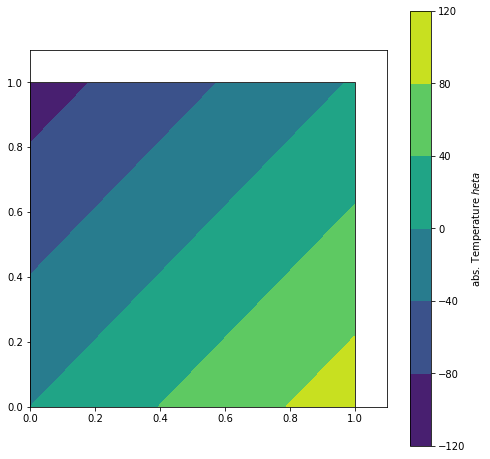

In [14]:
# create a new matplotlib plot containing of a fig (the canvas) and a ax (the graph) 
fig, ax = plt.subplots(1,1, figsize=(8.0, 8.0))

# use ShowMesh to plot into the axes
# here we plot the postprocessing field 'T' which are the nodal temperatures
temperatureplot = MyFirstSimulation.ShowMesh(ax, PostName='T')

# adding a legend with a proper description
legend = fig.colorbar(temperatureplot)
legend.ax.set_ylabel('abs. Temperature $\theta$')

# visualize the plot in any case
plt.show()

Also we can take a look at the whole degree of freedom vector. Note that this is organized in a nodal fashion, such that its order is the same as the nodal coodrinates we provided in the problem definition.

In [15]:
# get the actual degree of freedom vector
MyFirstSimulation.DI

array([  0. , 101.5,   3. , -98.5])

We can see that the essential boundary conditions are actually satisfied by the prescribed values 0 and 3. On the upper left corner we have set a positive load value, which indicates a heat flux out of the domain, resulting in the lowest temperature at this point. The opposite can be observed on the lower right corner, where a negative load value implies heat flix inside the domain.